**Authors:
Aïssétou Sogoba, Beatriz Ordoñez, Marta Montalbán**

### **1.ANALYSIS OF INPUT VARIABLES**

**Loading data and preparing data**

In [ ]:
import pandas as pd
import numpy as np
from termcolor import colored
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the JSON file into a DataFrame
import json
with open('full_format_recipes_def.json', 'r') as f:
    datos = json.load(f)
df = pd.DataFrame(datos)

**Eliminate null lines in dataset**

In [ ]:
# check if some lines contain NaN values for ratings, desc or directions
contains_nan = np.isnan(df['rating']).any()
df = df.dropna(subset=['rating', 'desc', 'directions'])

##Check if there are still in directions column for example
nan_indices = df[df['directions'].isna()].index
rows_with_nan = df.iloc[nan_indices]

**Saving the target column for later analysis**

In [ ]:
dfRatings=df['rating']

**Analysis of "Categories"**

In [ ]:
# Count the most common categories
category_counts = df['categories'].explode().value_counts()[:10]
top_categories = category_counts.index

df['categories'] = df['categories'].apply(lambda x: x if isinstance(x, list) else [])
filtered_data = df[df['categories'].apply(lambda x: any(cat in top_categories for cat in x))]

# Create a category-rating relationship
category_rating = filtered_data.explode('categories')
category_rating = category_rating[category_rating['categories'].isin(top_categories)]

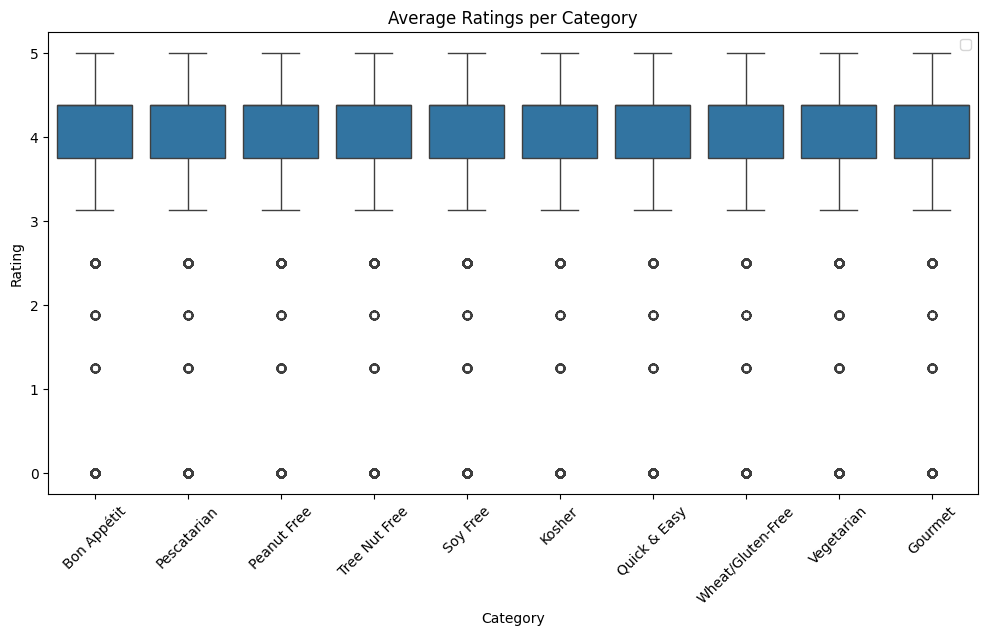

In [ ]:
# Plot average ratings per category
plt.figure(figsize=(12, 6))
sns.boxplot(x='categories', y='rating', data=category_rating)
plt.xticks(rotation=45)
plt.title('Average Ratings per Category')
plt.xlabel('Category')
plt.ylabel('Rating')
plt.legend()
plt.show()

**Correlation analysis**

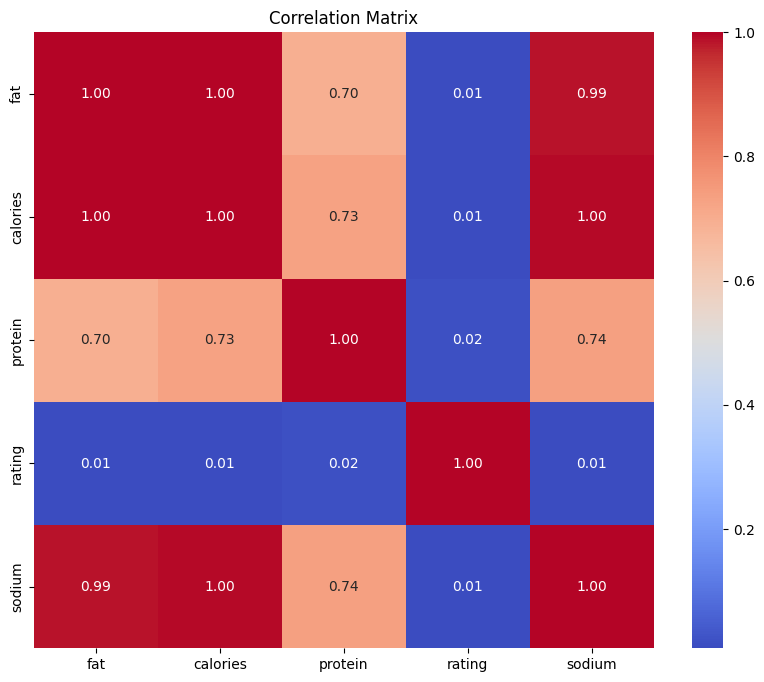

In [ ]:
# Analyze the correlation between numerical elements such as fat, calories... and rating
df_numeric = df.select_dtypes(include=['float64'])    # select numerical values between the input features of each recipe

#Compute the correlation matrix
correlation_matrix = df_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

### **2. IMPLEMENTATION OF A PIPELINE FOR TEXT PROCESSING**

*Preprocessing functions*

---



In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 1. Text preprocessing function
def preprocess_text(text):
    if isinstance(text, str):
      text = text.lower()                                           # convert the text to non capital letters
      text = re.sub(r'[^a-zA-Z0-9\s]', '', text)                    # remove special characters

    tokens = word_tokenize(text)                                    # Tokenization
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]    # remove stop words which are not interesting for our NLP
    return ' '.join(tokens)

# 2. Delete the "None" lines in the description columns
def handle_desc_column(value):
    if isinstance(value, list):
        value = ' '.join(value)
    # If the value is None or NaN
    if value is None:
        value = ''
    return str(value)

*Apply to our text*

---




> *1. Preprocess "Desc" column*

In [ ]:
df['processed_desc'] = df['desc'].apply(lambda x: preprocess_text(handle_desc_column(x)))

In [ ]:
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary

def tokenize(text_name):

    mycorpus = df[text_column].dropna().tolist()
    mycorpus = [word_tokenize(desc) for desc in mycorpus]

    # Dictionnary creation
    mycorpus_token = []
    for i in range(len(mycorpus)):
      mycorpus_i = [el.strip().split() for el in mycorpus[i]]
      mycorpus_token.append(mycorpus_i)

    # Dictionary of tokens
    D = Dictionary(mycorpus)
    n_tokens = len(D)

    print('The dictionary contains', n_tokens, 'terms')
    print('First terms in the dictionary:')
    for n in range(10):
        print(str(n), ':', D[n])

    # Determine the number of items in the created dictionary
    no_below = 4           #Minimum number of recipes to keep a term in the dictionary
    no_above = .80         #Maximum proportion of recipes in which a term can appear to be kept in the dictionary

    D.filter_extremes(no_below=no_below,no_above=no_above)
    n_tokens = len(D)
    print('The dictionary contains', n_tokens, 'terms')

    return mycorpus, D

In [ ]:
# Apply the tokenize function our input descriptions

text_column = 'processed_desc'
mycorpus, D = tokenize(text_column)

The dictionary contains 19879 terms
First terms in the dictionary:
0 : blanc
1 : boudin
2 : classic
3 : days
4 : found
5 : french
6 : ingredients
7 : sausage
8 : serving
9 : start
The dictionary contains 5764 terms




> *2. Identify the number of descriptions in which each token appears*

In [ ]:
#dataframe with 2 columns: token and ndesc, corresponding to the text of each token and the number of description where the token appears

def dataframe(dico):

  # dico is the dictionnary produced by the tokenization function
  df = pd.DataFrame([[token, D.dfs[idx]] for idx,token in D.items()], columns=['token', 'ndesc'])
  df.sort_values(by=['ndesc'], ascending=False, inplace=True, ignore_index=True)
  print('Number of tokens appearing in just one line :', sum(df['ndesc']==1))
  df = df[df['ndesc']>1]
  print(df)
  plt.hist(np.log10(df.ndesc.tolist()), bins=30)
  plt.show()

Number of tokens appearing in just one line : 0
             token  ndesc
0           recipe   2094
1             make   1403
2             dish   1276
3           flavor   1167
4          minutes   1123
...            ...    ...
5759          usda      4
5760         scent      4
5761    sheepsmilk      4
5762  slowroasting      4
5763   development      4

[5764 rows x 2 columns]


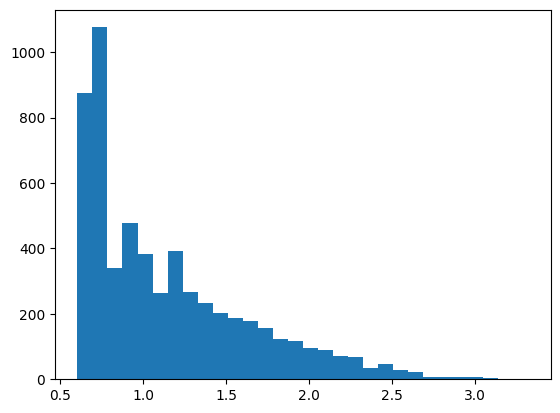

In [ ]:
dataframe(D)

> *3. Bag of words representation of the corpus*

In [ ]:
mycorpus_bow = [D.doc2bow(desc) for desc in mycorpus]       # transforms token list to lits of (token_id, n= number of occurence of token)

# Check for row 1000
print("Recipe", ' '.join(mycorpus[10]))
print("Sparse vector representation", mycorpus_bow[1000])
print("Word counts",list(map(lambda x: (D[x[0]], x[1]), mycorpus_bow[1000])))

Recipe recipe prepared 45 minutes less
Sparse vector representation [(33, 1), (105, 1), (112, 1), (129, 1), (165, 1), (168, 1), (226, 1), (490, 1), (920, 1), (1568, 1)]
Word counts [('serve', 1), ('dish', 1), ('side', 1), ('first', 1), ('chicken', 1), ('course', 1), ('beef', 1), ('grilled', 1), ('bed', 1), ('arugula', 1)]


### **3. VECTOR REPRESENTATION OF THE DOCUMENTS USING THREE DIFFERENT PROCEDURES**

*TD-IDF, Word2Vec model and with transformers*

---



**A. TF-IDF**

In [ ]:
from gensim.models import TfidfModel

tfidf = TfidfModel(mycorpus_bow)              # Prepare the module TD-IDF with the corpus
mycorpus_tfidf = tfidf[mycorpus_bow]          # Apply it to the corpus

## Probamos para la fila 1000
n_project = 1000
TFidf = tfidf[mycorpus_bow[n_project]]

**B. WORD2VEC**

In [ ]:
from gensim.models import Word2Vec
import numpy as np

# We use the tokenized elements stored in mycorpus for Word2Vec

# Create the model
w2v_model = Word2Vec(sentences= mycorpus, vector_size=100, window=5, min_count= 1, workers=4)

# Represent descriptions as average of word embeddings
def average_word2vec(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)  # when the desc contains some words that are not in the vocab of the word2Vec

X_w2v = np.vstack([average_word2vec(desc, w2v_model) for desc in mycorpus])

In [ ]:
print(X_w2v)

[[-0.14211498  0.63790351  0.13951096 ... -0.64551771 -0.15754543
   0.131409  ]
 [ 0.03495948  0.25103334 -0.22032236 ... -0.38158625 -0.13103276
   0.57240224]
 [-0.21637774  0.88376302  0.95433503 ... -1.60928595  0.46409863
  -0.38877165]
 ...
 [-0.07738919  0.51570159 -0.08252226 ... -0.52674133 -0.26482496
   0.48226556]
 [-0.09389361  0.35907072  0.05036659 ... -0.44708252 -0.12317699
   0.24581677]
 [-0.11416842  0.43585134 -0.00577505 ... -0.50332022 -0.18299371
   0.34442711]]


**C. TRANSFORMERS**


> *1. Importing necessary things*

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
!pip install torch

*2. Transformer configuration*

In [ ]:
from transformers import RobertaTokenizer, RobertaModel
import torch
from datasets import load_dataset

In [ ]:
# Cargar el dataset with Hugging Face
dataset = load_dataset("json", data_files="full_format_recipes_def.json", split='train')
dataset_desc = dataset.map(lambda example: {'desc': example['desc']}, remove_columns=[col for i, col in enumerate(dataset.column_names) if i != 5])

# Cargar el tokenizer y el modelo RoBERTa preentrenado
tokenizer = RobertaTokenizer.from_pretrained("roberta-base" )
model = RobertaModel.from_pretrained("roberta-base")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/20130 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Function to obtain the embeddings of the texts
def get_roberta_embeddings(texts):

    # Tokenize texts
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512).to(device)
    inputs = inputs.to(device)

    # Obtain outputs of RoBERTa model
    with torch.no_grad():
        outputs = model(**inputs)

    # Save embeddings of last layer
    embeddings = outputs.last_hidden_state.mean(dim=1)

    return embeddings.cpu().numpy()

In [ ]:
removed_indices = []

def process_desc_column(batch):

    desc_texts = [desc for desc in batch['desc'] if desc is not None and desc != ""]
    if desc_texts:
        embeddings = get_roberta_embeddings(desc_texts)                                # Process all descriptions in a batch
        return {'desc_embeddings': [embed.squeeze().numpy() for embed in embeddings]}  # Return numpy arrays
    else:
        return {'desc_embeddings': []}                                                 # Return empty list for invalid rows

def filter_and_store_removed_indices(example, idx):
    if example['desc'] is None or example['desc'] == "":
        removed_indices.append(idx)
        return False
    return True

*3. Apply to our data*

In [ ]:
# filter invalid lines
filtered_dataset = dataset.filter(filter_and_store_removed_indices, with_indices= True)

# Generate and save embeddings
batch_size = 16
all_embeddings = []

for i in range(0, len(filtered_dataset), batch_size):
    batch = filtered_dataset[i : i + batch_size]
    desc_texts = batch["desc"]  # Extract descriptions
    embeddings = get_roberta_embeddings(desc_texts)
    all_embeddings.extend(embeddings)


# Convert to a NumPy array and save
all_embeddings = np.array(all_embeddings)
np.save("desc_embeddings.npy", all_embeddings)
print(f"Saved embeddings to 'desc_embeddings.npy'")

Filter:   0%|          | 0/20130 [00:00<?, ? examples/s]

Saved embeddings to 'desc_embeddings.npy'


*4. Use of PCA for dimensionality reduction*

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)  # Reduce to n_components dimension
reduced_embeddings = pca.fit_transform(all_embeddings)

# Save the reduced embeddings
np.save("desc_embeddings_pca.npy", reduced_embeddings)
print(f"Saved reduced embeddings to 'desc_embeddings_pca.npy'")

# Save PCA components
np.save("pca_components.npy", pca.components_)

Saved reduced embeddings to 'desc_embeddings_pca.npy'


*5. Load saved embeddings*

In [ ]:
loaded_embeddings_no_pca = np.load("desc_embeddings.npy")     # without use of PCA

loaded_embeddings = np.load("desc_embeddings_pca.npy")        # for reduced one after use of PCA
print(f"Loaded embeddings shape: {loaded_embeddings.shape}")

ratings = np.array(filtered_dataset["rating"])  # Convert to a NumPy array

Loaded embeddings shape: (13495, 100)
<class 'numpy.ndarray'>


### **4. TRAINING AND EVALUATION OF REGRESSION MODELS**

##**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

def Random_forest(X,y):

    # split data into training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    # Train Random Forest
    rf_model = RandomForestRegressor()
    rf_model.fit(X_train, y_train)

    # 9. Hacer predicciones
    y_pred = rf_model.predict(X_test)

    # 10. Evaluar el modelo
    mse = mean_squared_error(y_test, y_pred)
    r_score = r2_score(y_test , y_pred)
    return(f'Mean Squared Error: {mse}, R² Score:{r_score}')

*Prepare "Rating" column, apply corresponding filter for model evaluation*

In [ ]:
# delete rows where directions or descriptions or ratings is a NaN
contains_nan = np.isnan(df['rating']).any()
df = df.dropna(subset=['rating', 'desc', 'directions'])

# Find rows where rating is NaN to check the suppression
nan_indices = df[df['rating'].isna()].index

# Retrieve rows with NaN in the rating column in case
rows_with_nan = df.iloc[nan_indices]

*1. Transformers evaluation with Random forest*

---



In [ ]:
Random_forest(loaded_embeddings,df['rating'])

'Mean Squared Error: 1.649033104491834, R² Score:0.04609273692251947'

*2. Word2vec evaluation with Random forest*

---



In [ ]:
Random_forest(X_w2v, df['rating'])

'Mean Squared Error: 1.4076628315248096, R² Score:0.1713664051413416'

*Convert the TD-IDF vectors into a sparse matrix for evaluation*



In [ ]:
from gensim.matutils import corpus2csc
from scipy.sparse import csr_matrix

sparse_matrix = corpus2csc(mycorpus_tfidf).T  # Transpose to match (n_samples, n_features)
sparse_matrix = csr_matrix(sparse_matrix)

print("Shape of mycorpus_tfidf:", sparse_matrix.shape)
print("Shape of df['rating']:", len(df['rating']))

Shape of mycorpus_tfidf: (13484, 5764)
Shape of df['rating']: 13484


*TF IDF evaluation with Random forest*

---



In [ ]:
Random_forest(sparse_matrix, df['rating'])

'Mean Squared Error: 1.6614444019639383, R² Score:0.021975563590131086'

##**Neural Netwok**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Create a PyTorch model
class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super(RegressionNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.fc(x)


In [ ]:
def NN_eval(X, y):

    # Data splitting into train and test dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)    # add a dimension for regression

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Initialize model, loss, and optimizer
    model = RegressionNN(input_dim=X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop over number of epochs
    for epoch in range(5):                    # Training for 5 epochs
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # Model evaluation
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
        predictions = model(X_test_tensor)
        test_loss = criterion(predictions, y_test_tensor)
        print(f"Test Loss: {test_loss.item()}")

        predictions_np = predictions.numpy()   # convert predictions to NumPy array
        r2 = r2_score(y_test, predictions_np)  # compute R^2 score
        print(f"R^2 Score: {r2}")

*1. Evaluation of Word2vec with Neural Networks*

---



In [ ]:
NN_eval(X_w2v, dfRatings.to_numpy())

Test Loss: 1.6864477396011353
R^2 Score: 0.007257170091883203


*2. Evaluation of TF - IDF with Neural networks*

---



In [ ]:
NN_eval(sparse_matrix.toarray(), dfRatings.to_numpy())

Test Loss: 2.020533800125122
R^2 Score: -0.18940579842017824


*3. Evaluation of transformers with Neural networks*

---



In [ ]:
NN_eval(loaded_embeddings, df['rating'])

Test Loss: 1.7052029371261597
R^2 Score: 0.013600423258043337


##**Comparison**

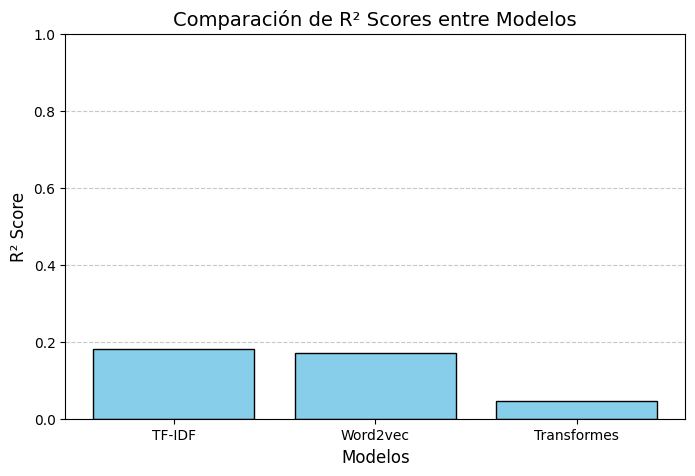

In [ ]:
import matplotlib.pyplot as plt

# Nombres de los modelos y R^2 scores
models = ["TF-IDF", "Word2vec", "Transformes"]
r2_scores = [0.18063449140055166, 0.1713664051413416, 0.04609273692251947]

# Crear el gráfico de barras
plt.figure(figsize=(8, 5))  # Tamaño del gráfico
plt.bar(models, r2_scores, color='skyblue', edgecolor='black')

# Etiquetas y título
plt.xlabel("Modelos", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.title("Comparación de R² Score entre Modelos", fontsize=14)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.show()


### **Fine-tuning a pre-trained model from Hugging Face**

In [ ]:
dataset = load_dataset("json", data_files="full_format_recipes_def.json", split='train')

removed_indices = []
def filter_and_store_removed_indices(example, idx):
    if not example['desc'] or example['desc'].strip() == "" or example['rating'] is None:
        removed_indices.append(idx)  # Registrar el índice de la fila eliminada
        return False  # Filtrar esta fila
    return True  # Conservar esta fila                                            # Mantener esta fila

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
from sklearn.model_selection import train_test_split

filtered_dataset = dataset.filter(filter_and_store_removed_indices, with_indices= True)

## We generate test and train sets for future evaluation

train_test_split_result = filtered_dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split_result['train']
eval_dataset = train_test_split_result['test']

print(filtered_dataset.shape)
print(filtered_dataset.column_names)

Filter:   0%|          | 0/20130 [00:00<?, ? examples/s]

(13484, 11)
['directions', 'fat', 'date', 'categories', 'calories', 'desc', 'protein', 'rating', 'title', 'ingredients', 'sodium']


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize_batch(batch):
    tokenized_batch = tokenizer(batch["desc"], padding= 'max_length', truncation=True, return_tensors="pt", max_length=246)
    return tokenized_batch

tokenized_dataset = train_dataset.map(tokenize_batch, batched=True)
print(tokenized_dataset.shape)
print(tokenized_dataset[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/10787 [00:00<?, ? examples/s]

(10787, 13)
{'directions': ['Lightly oil a baking sheet.', 'In a dry heavy saucepan cook sugar over moderate heat, stirring with a fork, until melted and cook, without stirring, swirling pan, until a golden caramel. Stir in pecans with salt until coated well. Immediately pour mixture onto baking sheet, tilting baking sheet to make a thin layer, and cool completely, about 20 minutes. Carefully remove praline in shards from baking sheet. Break about one eighth shards into smaller pieces and in a food processor pulse until ground coarse. Break remaining praline into 12 shards for garnishing desserts. Praline may be made 2 days ahead, ground praline kept in an airtight container at cool room temperature (if it clumps, regrind in food processor before using), and shards kept between sheets of wax paper in another airtight container at room temperature.'], 'fat': 7, 'date': Timestamp('2004-08-20 12:48:48+0000', tz='UTC'), 'categories': ['Candy', 'Nut', 'Dessert', 'Bake', 'Quick & Easy', 'Pec

Check the lengths after tokenization

In [ ]:
print(len(tokenized_dataset['input_ids'][0]))
print(len(tokenized_dataset['attention_mask'][0]))
lengths =[len(seq) for seq in tokenized_dataset['input_ids']]
print(lengths)
if any(length != 246 for length in lengths):

    print("Hay secuencias con longitud distinta a 246")
else:
    print("Todas las secuencias tienen longitud 246")

246
246
[246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 2

In [ ]:
from transformers import AutoModelForSequenceClassification

# Cargar el modelo preentrenado con la cabeza de regresión (un solo valor de salida)
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=1)

# Mover el modelo al dispositivo adecuado (GPU si está disponible)
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
input_ids_tensor = torch.tensor(tokenized_dataset['input_ids'])
attention_mask_tensor = torch.tensor(tokenized_dataset['attention_mask'])
labels_tensor = torch.tensor(tokenized_dataset['rating'])
print(input_ids_tensor.shape, attention_mask_tensor.shape, labels_tensor.shape)

torch.Size([10787, 246]) torch.Size([10787, 246]) torch.Size([10787])


In [ ]:
import torch
from torch.optim import AdamW
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

batch_size = 16
dataset = TensorDataset(input_ids_tensor, attention_mask_tensor, labels_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()

# Train the model
for epoch in range(3):
    model.train()
    epoch_loss = 0.0

    for batch in data_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device).float()

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = outputs.logits.squeeze()

        loss = criterion(predictions, labels)
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Average Loss: {epoch_loss / len(data_loader)}")

model.save_pretrained("./trained_model")
tokenizer.save_pretrained("./trained_model")

Epoch 1, Average Loss: 1.9547927333690502
Epoch 2, Average Loss: 1.7057880015726443
Epoch 3, Average Loss: 1.6140284352611611


('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 './trained_model/vocab.json',
 './trained_model/merges.txt',
 './trained_model/added_tokens.json',
 './trained_model/tokenizer.json')

*Apply trained model to our data, using test dataset*

In [ ]:
tokenized_datasetTEST = eval_dataset.map(tokenize_batch, batched=True)

Map:   0%|          | 0/2697 [00:00<?, ? examples/s]

246
246
[246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 2

Create tensors of tokenized test dataset

In [ ]:
input_ids_tensorTEST = torch.tensor(tokenized_datasetTEST['input_ids'])
attention_mask_tensorTEST = torch.tensor(tokenized_datasetTEST['attention_mask'])
labels_tensorTEST = torch.tensor(tokenized_datasetTEST['rating'])
print(input_ids_tensorTEST.shape, attention_mask_tensorTEST.shape, labels_tensorTEST.shape)

torch.Size([2697, 246]) torch.Size([2697, 246]) torch.Size([2697])


Apply model

In [ ]:
batch_size = 16
test_dataset = TensorDataset(input_ids_tensorTEST, attention_mask_tensorTEST, labels_tensorTEST)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model.eval()
total_loss = 0.0
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device).float()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze()

        predictions.extend(logits.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        loss = criterion(logits, labels)
        total_loss += loss.item()

average_loss = total_loss / len(test_loader)
print(f"Pérdida promedio en el conjunto de prueba: {average_loss}")

Pérdida promedio en el conjunto de prueba: 1.727661346278247


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(true_labels, predictions)
mae = mean_absolute_error(true_labels, predictions)
r2 = r2_score(true_labels, predictions)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

MSE: 1.7303
MAE: 0.8292
R²: 0.0424


##**Project extension**

In [ ]:
# vectorization using BPE with tokenizer

from tokenizers import Tokenizer, models, trainers, pre_tokenizers
from tokenizers.trainers import BpeTrainer

descriptions = df['desc'].dropna().tolist()  # Drop any null values

# Combine the list of descriptions into a single list of sentences
texts = [desc for desc in descriptions if isinstance(desc, str)]

tokenizer = Tokenizer(models.BPE())

# Pre-tokenizer splits text into words and subwords
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

# we define the trainer with a given vocab size and some special tokens
trainer = BpeTrainer(vocab_size=5000, min_frequency=2, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]"])

# Training of the tokenizer on the list of recipe descriptions
tokenizer.train_from_iterator(texts, trainer)

# Then we save the tokenizer for later use
tokenizer.save("bpe_tokenizer.json")
print("Tokenizer trained and saved as 'bpe_tokenizer.json'")

Tokenizer trained and saved as 'bpe_tokenizer.json'


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

tokenizer = Tokenizer.from_file("bpe_tokenizer.json")

# Encode all descriptions
def encode_descriptions(texts):
    return [tokenizer.encode(text).ids for text in texts]       # Convert each description to token IDs using the tokenizer

encoded_descriptions = encode_descriptions(descriptions)

# Since RandomForest doesn't support variable-length inputs, pad sequences to the same length
max_len = max(len(seq) for seq in encoded_descriptions)       # Determine the maximum sequence length


padded_descriptions = np.array([seq + [0] * (max_len - len(seq)) for seq in encoded_descriptions])   # Pad all sequences to the maximum length

print(f"Padded encoded descriptions shape: {padded_descriptions.shape}")

Padded encoded descriptions shape: (13484, 490)


In [ ]:
Random_forest(padded_descriptions, df['rating'])

'Mean Squared Error: 1.5551816774332363, R² Score:0.08452808785616595'

##**Analysis with three features combined: directions, descriptions, categories**

In [ ]:
# process the directions
df['processed_directions'] = df['directions'].apply(lambda x: preprocess_text(handle_desc_column(x)))

# put each processed data as a string again for joining later

df['processed_directions'] = df['processed_directions'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
df['processed_desc'] = df['processed_desc'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
df['categories'] = df['categories'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

# Join them into a unique feature
df['processed_directions_desc_categories'] = (df['processed_desc'] + ' ' + df['processed_directions'] + ' ' + df['categories'])


In [ ]:
# check if some lines contain NaN values for ratings, desc or directions and remove them

df = df.dropna(subset=['rating', 'desc', 'directions'])

In [ ]:
text_column_3_variables = 'processed_directions_desc_categories'

# tokenize this input data
mycorpus_2, D_2 = tokenize(text_column_3_variables)

# create the model for word2vec
w2v_model_2 = Word2Vec(sentences = mycorpus_2, vector_size=100, window=5, min_count= 1, workers=4)

# get the vectors
X_w2v_2 = np.vstack([average_word2vec(data, w2v_model) for data in mycorpus_2])


The dictionary contains 19879 terms
First terms in the dictionary:
0 : blanc
1 : boudin
2 : classic
3 : days
4 : found
5 : french
6 : ingredients
7 : sausage
8 : serving
9 : start
The dictionary contains 5764 terms


In [ ]:
# evaluation of word2vec with three features
Random_forest(X_w2v_2, df['rating'])

'Mean Squared Error: 1.5661794699829648, R² Score:0.07805413672816763'

In [ ]:
# TD-IDF
mycorpus_bow_2 = [D.doc2bow(desc) for desc in mycorpus_2]
from gensim.models import TfidfModel
tfidf_2 = TfidfModel(mycorpus_bow_2)              # to prepare the module TD-IDF with the corpus
mycorpus_tfidf_2 = tfidf_2[mycorpus_bow_2]          # apply it to the corpus

TFidf_2 = tfidf_2[mycorpus_bow_2[n_project]]

In [ ]:
from gensim.matutils import corpus2csc
from scipy.sparse import csr_matrix

# Convert TransformedCorpus to a SciPy sparse matrix
sparse_matrix_2 = corpus2csc(mycorpus_tfidf_2).T  # Transpose to match (n_samples, n_features)

# Ensure it is in CSR format
sparse_matrix_2 = csr_matrix(sparse_matrix_2)

In [ ]:
Random_forest(sparse_matrix_2, df['rating'])

'Mean Squared Error: 1.6592607855772863, R² Score:0.023260969339108373'